In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

In [16]:
# 모델 정읳
def get_mnist_model():
    # 입력 28x28 이미지를 1차원 벡터(784 차원)로 입력
    inputs = keras.Input(shape=(28 * 28,))

    # 512개의 노드, ReLU 활성화 함수 사용
    features = layers.Dense(512, activation="relu")(inputs)

    # 과적합 방지를 위한 Dropout (50% 확률로 뉴런 비활성화)
    features = layers.Dropout(0.5)(features)

    # 출력층: 10개의 클래스에 대한 확률값 출력 (softmax 활성화 함수 사용)
    outputs = layers.Dense(10, activation="softmax")(features)

    model = keras.Model(inputs, outputs)
    return model

# dataset load & split
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [22]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)


# 사용자 정의 지표 사용 모델

In [17]:
class RootMeanSquaredError(keras.metrics.Metric):
    # Metric 상속
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)

        # MSE 총합 저장, 샘플 수 저장
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # true 레이블 원핫 인코딩으로 바꾸기
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])

        # pred와 true 사이의 MSE계산
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)

        # 지금 배치 샘플 수 계산, 총 샘플 수 업데이트
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    # MSE계산 후 RMSE로 바꾸기
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    # 에포크 또는 평가 후 상태 초기화
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [18]:
model = get_mnist_model()

# 모델을 컴파일
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])

# 모델을 학습
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))

# 테스트 데이터에 대해 모델 성능을 평가
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8646 - loss: 0.4452 - rmse: 0.4371 - val_accuracy: 0.9532 - val_loss: 0.1553 - val_rmse: 0.2636
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9503 - loss: 0.1665 - rmse: 0.2726 - val_accuracy: 0.9660 - val_loss: 0.1214 - val_rmse: 0.2302
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9623 - loss: 0.1274 - rmse: 0.2396 - val_accuracy: 0.9726 - val_loss: 0.0979 - val_rmse: 0.2037
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9713 - loss: 0.1042 - rmse: 0.2122


In [20]:
test_metrics #loss, acc, rmse

[0.08987199515104294, 0.9746999740600586, 0.19931164383888245]

# 사용자 정의 콜백 정의


In [23]:
class LossHistory(keras.callbacks.Callback):
    # Calback 상속

    # 학습 시작할 때 호출
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    # 배치 끝날 때 호출
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    # 에포크 끝날 때 호출
    def on_epoch_end(self, epoch, logs):
        # 기존 플랏 데이터 삭제
        plt.clf()

        # 배치 별 loss plot
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()

        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8634 - loss: 0.4508 - val_accuracy: 0.9608 - val_loss: 0.1400
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9512 - loss: 0.1677 - val_accuracy: 0.9662 - val_loss: 0.1186
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9630 - loss: 0.1277 - val_accuracy: 0.9726 - val_loss: 0.1010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9692 - loss: 0.1045 - val_accuracy: 0.9757 - val_loss: 0.0963
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9707 - loss: 0.0993 - val_accuracy: 0.9773 - val_loss: 0.0948
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9730 - loss: 0.1009 - val_accuracy: 0.9769 - val_loss: 0.0975
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9779 - loss: 0.0871 - val_accuracy: 0.9754 - val_loss: 0.0985
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9776 - loss: 0

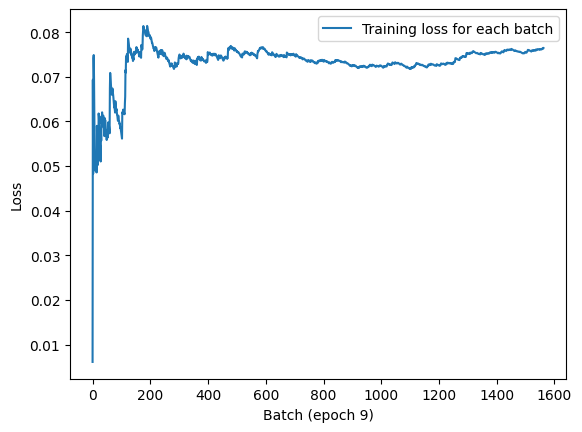

In [24]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))